# <center> <font color='blue'> **An Algorithm for Passive Microwave Precipitation Retrievals: Transfer Learning from Reanalysis Data to Multi-satellite Observations using Boosted Decision Trees** <center>

#### <center> <font color='balck'> Buddha Subedi, Mahyar Garshasbi, Ardeshir Ebtehaj <center>
#### <center> Saint Anthony Falls Laboratory, Department of Civil Environmental and Geo- Engineering, 
#### <center> University of Minnesota <center>
#### <center> Date: May, 2025 (rev 01)

---
<p align="justify"> This notebook representes the results of an algorithm, called the Boosted tRansfer-leArning for PMW precIpitationN Retrievals (B-RAINS) for passive microwave retrieval of precipitation. B-RAINS enables (i) the integration of the information content from ESMs into the retrieval process and (ii) the fusion of multi-satellite observations across varying spatial and temporal resolutions through meta-model learning. The architecture leverages transfer learning by incorporating low-level priors from ESMs and refining them with high-level features derived from satellite-based active retrievals, enhancing accuracy in regions and periods with limited training data. The algorithm first detects the precipitation occurrence and phase and then estimates its rate, while conditioning the results to some key cloud microphysical and environmental variables as further explained later on in Section 1.2. Through ensemble meta-modeling, B-RAINS combines data from multiple spaceborne radars operating at Ka, Ku, and W bands to improve the detection of rainfall and snowfall. Application and validation using data from the Global Precipitation Measurement (GPM) mission and CloudSat's Cloud Profiling Radar (CPR) show that B-RAINS achieves comparable accuracy to existing methods for rain retrievals and delivers substantial improvements in global snowfall estimates when benchmarked against version V07 of the official GPM data products and Multi-Radar/Multi-Sensor System (MRMS) precipitation estimates over the contiguous United States.

This notebook is organized as follows. Section 1, describes the data including the GPM and CloudSat products as well as the ERA5 reanalysis data from the European Centre for Medium-Range Weather Forecasts (ECMWF). Section 2 describes the methodolgy for training the networks, and the last section provides an example for precipitation orbital retrieval using the proposed algorithm.

# **1. Data**

**1.1** **Data Description**

In this study, we considered coincidences of GMI and CPR from April 2014 to July 2019, and coincidences of GMI and DPR data in 2015 and 2023. Furthermore, ancillary information related to atmospheric conditions, surface types and topography are added to all coincidences using the [ERA5](https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era5) reanalysis products -- available at spatial resolution of 31km and [GTOPO](https://www.usgs.gov/centers/eros/science/usgs-eros-archive-digital-elevation-global-30-arc-second-elevation-gtopo30) -- available at spatial resolution of 1km. 

**Atmospheric Variables**
*   tclw = Total Column Cloud Liquid Water ($\rm kg/m^2$)
*   tciw = Total Column Cloud Ice Water ($\rm kg/m^2$)
*   tcwv = Total Column Water Vapor ($\rm kg/m^2$)
*   cape = Convective Available Potential Energy ($\rm j/kg$)
*   t2m = 2m air temperature ($\rm K$)
*   u10 = 10m u-component of wind ($\rm m/s$)
*   v10 = 10m v-component of wind ($\rm m/s$)
*   tcslw = Total Column Supercooled Liquid Water ($\rm \frac{kg}{m^2}$)
*   tcw = Total Column Water ($\rm \frac{kg}{m^3}$)
*   cin = Convective Inhibition ($\rm j/kg$)

**Surface Type Variables**
*   lsm = LandSeaMask
*   siconc = Sea Ice Area Fraction
*   sd = Snow Depth ($\rm m$)
*   asn = Snow Albedo
*   rsn = Snow Density
*   swvl1 = Volumetric Soil Water Layer1 (-)

**Orographic Variables**
* Elevation
* Aspect

The GMI-CPR coincidences rely on the level-II CloudSat products (R05) including the 2C-PRECIP-COLUMN  and the 2C-SNOW-PROFILE that contains near-surface rain and snowfall rates.  To avoid ground-clutter contamination over complex elevated terrains, the near-surface snowfall rate is reported at 3rd (5th) radar bin above the oceans (land) at 720 (1200) m above the surface.

The 2A-DPR product, retrieved from Ku-band reflectivity, consists the near-surface precipitation phase and its intensity. It should be noted that the DPR algorithm uses precipitation phase at the lowest radar range gate uncontaminated by surface clutter, which may be 0.5--2.0 km above the surface (even over oceans). 

Figure 1, represents the way the coincidences between GMI and CloudSat profiling radar (CPR) and GMI and DPR are collected. For more details with respect to the CloudSat and GMI please refer to ([2](https://journals.ametsoc.org/view/journals/hydr/22/7/JHM-D-20-0296.1.xml)).

<img src="coincidence_image.png" alt="Coincidence Image" width="800">

***Figure 1***.  Schematic of a CloudSat-GPM coincidence segment (left), and DPR-GMI coincidence (right)

Resolution mismatches between input and output data sources can introduce information redundancy and exacerbate the inherent non-uniqueness of the inverse problem in precipitation retrievals. In this study, all retrievals are performed at the nominal footprint resolution of GMI pixels (5.1$\times$13.2~km). The total number of samples, after harmonization, in phase detection (rate estimation) is 7,000,000 (1,000,000) for ERA5, 250,000 (47,123) for CPR, and 2,800,000 (1,700,000) for DPR coincidences. The data sets are partitioned into 70, 15, and 15 percent for training, testing, and validation.

## **1.2 Database Organization and Loading**

**Inputs for the phase detection and rate estimation are as follows:**
> **Inputs:**

*   $\text{TB} = X_{train}(:,1:13)$ (Brightness Temperature at 13 GMI channels [K])
*   $ \text{tciw} = X_{train}(:,14)$ (Cloud Liquid Water Path)
*   $\text{tclw} = X_{train}(:,15)$ (Cloud Ice Water Path)
*   $\text{tcwv} = X_{train}(:,16)$ (2-meter Air Temperature)
*   $\text{t2m} = X_{train}(:,17)$ (Water Vapor Path)
*   $\text{cape} = X_{train}(:,18)$ (Convective Potential Energy)

*   $\text{u10} = X_{train}(:,19)$ (10m u-component of wind)
*   $ \text{v10} = X_{train}(:,20)$ (10m v-component of wind)
*   $\text{skt} = X_{train}(:,21)$ (Skin Temperature)
*   $\text{asn} = X_{train}(:,22)$ (Snow Albedo)
*   $\text{rsn} = X_{train}(:,23)$ (Snow Density)
*   $\text{cin} = X_{train}(:,24)$ (Convective Inhibition)

*   $\text{sd} = X_{train}(:,25)$ (Snow Depth)
*   $ \text{tcslw} = X_{train}(:,26)$ (Total Column Supercooled Liquid Water)
*   $\text{tcw} = X_{train}(:,27)$ (Total Column Water)
*   $\text{swvl1} = X_{train}(:,28)$ (Soil Water Volumetric Layer 1)
*   $\text{lsm} = X_{train}(:,29)$ (Snow Density)
*   $\text{siconc} = X_{train}(:,30)$ (Convective Inhibition)

*   $\text{Latitude} = X_{train}(:,31)$ (Snow Depth)
*   $ \text{Longitude} = X_{train}(:,32)$ (Total Column Supercooled Liquid Water)
*   $\text{Month} = X_{train}(:,33)$ (Total Column Water)
*   $\text{Day} = X_{train}(:,34)$ (Snow Albedo)
*   $\text{Elevation} = X_{train}(:,35)$ (Snow Density)
*   $\text{Aspect} = X_{train}(:,36)$ (Convective Inhibition)


> **Outputs:**

*   Output of the phase network is a vector containing three integer values **0 (no precipitation)**, **1 (rainfall)**, and **2 (snowfall)**

**For the precipitation estimation, the inputs and outputs are as follows:**

> **Inputs:**

*    $\text{TB} = X_{train}(:,1:13)$ (Brightness Temperature at 13 GMI channels [K])
*   $X_k = X_{train}(:,14:36)$  (Snowfall/rainfall rate of *k*-nearest neighbors ($k=20$) of the observed TBs in the training set.)

> **Outputs**:

*   Output of the estimation network is a vector containing rainfall/snowfall rate [$\rm mm.hr^{-1}$].

In [1]:
import numpy as np
import pandas as pd
paths = {
    'cpr': r'G:\Shared drives\SAFL Ebtehaj Group\Buddha Research\Research 1\data\df_cpr_phase.npz',
    'dpr': r'G:\Shared drives\SAFL Ebtehaj Group\Buddha Research\Research 1\data\df_dpr_phase.npz',
    'era5': r'G:\Shared drives\SAFL Ebtehaj Group\Buddha Research\Research 1\data\df_era5_phase.npz'
}

data = {k: np.load(p) for k, p in paths.items()}
df_cpr_phase, df_dpr_phase, df_era5_phase = (pd.DataFrame({k: v[k] for k in v.files}) for v in data.values())

for name, df, sep in zip(
    ['ERA5', 'CPR', 'DPR'],
    [df_era5_phase, df_cpr_phase, df_dpr_phase],
    ['##############################', '##############################', '']
):
    counts = df['Prcp flag'].value_counts().sort_index()
    print(f"**{name}**\nTotal samples for classification: {len(df)}")
    print(f"Clear: {counts.get(0,0)}, Rain: {counts.get(1,0)}, Snow: {counts.get(2,0)}")
    if sep: print(sep)

**ERA5**
Total samples for classification: 7000000
Clear: 3500000, Rain: 2500000, Snow: 1000000
##############################
**CPR**
Total samples for classification: 240800
Clear: 120400, Rain: 86000, Snow: 34400
##############################
**DPR**
Total samples for classification: 2800000
Clear: 1400000, Rain: 1000000, Snow: 400000


The ratio between the clear (0), rain(1) and snow(2) is 3.5:2.5:1 for the detection task

In [2]:
import numpy as np
import pandas as pd

paths = {
    'train': r'G:\Shared drives\SAFL Ebtehaj Group\Buddha Research\Research 1\data\era5_phase_train.npz',
    'test': r'G:\Shared drives\SAFL Ebtehaj Group\Buddha Research\Research 1\data\era5_phase_test.npz',
    'val': r'G:\Shared drives\SAFL Ebtehaj Group\Buddha Research\Research 1\data\era5_phase_val.npz'
}

data = {k: np.load(p) for k, p in paths.items()}
df_70_train_era5, df_15_test_era5, df_15_val_era5 = (pd.DataFrame({k: v[k] for k in v.files}) for v in data.values())

for name, df, sep in zip(
    ['Train', 'Test', 'Validation'],
    [df_70_train_era5, df_15_test_era5, df_15_val_era5],
    ['##############################', '##############################', '']
):
    counts = df['Prcp flag'].value_counts().sort_index()
    print(f"**{name}**\nTotal samples for classification: {len(df)}")
    print(f"Clear: {counts.get(0,0)}, Rain: {counts.get(1,0)}, Snow: {counts.get(2,0)}")
    if sep: print(sep)

**Train**
Total samples for classification: 4900000
Clear: 2450737, Rain: 1749424, Snow: 699839
##############################
**Test**
Total samples for classification: 1050000
Clear: 524967, Rain: 375110, Snow: 149923
##############################
**Validation**
Total samples for classification: 1050000
Clear: 524296, Rain: 375466, Snow: 150238


In [3]:
paths = {
    'training samples': r'G:\Shared drives\SAFL Ebtehaj Group\Buddha Research\Research 1\data\cpr_phase_train.npz',
    'testing samples':  r'G:\Shared drives\SAFL Ebtehaj Group\Buddha Research\Research 1\data\cpr_phase_test.npz',
    'validation samples': r'G:\Shared drives\SAFL Ebtehaj Group\Buddha Research\Research 1\data\cpr_phase_val.npz'
}

data = {k: np.load(p) for k, p in paths.items()}
df_70_train_cpr, df_15_test_cpr, df_15_val_cpr = (pd.DataFrame({k: v[k] for k in v.files}) for v in data.values())

for name, df, sep in zip(
    ['Train', 'Test', 'Validation'],
    [df_70_train_cpr, df_15_test_cpr, df_15_val_cpr],
    ['##############################', '##############################', '']
):
    counts = df['Prcp flag'].value_counts().sort_index()
    print(f"**{name}**\nTotal samples for classification: {len(df)}")
    print(f"Clear: {counts.get(0,0)}, Rain: {counts.get(1,0)}, Snow: {counts.get(2,0)}")
    if sep: print(sep)

**Train**
Total samples for classification: 168560
Clear: 84279, Rain: 60318, Snow: 23963
##############################
**Test**
Total samples for classification: 36120
Clear: 17974, Rain: 12923, Snow: 5223
##############################
**Validation**
Total samples for classification: 36120
Clear: 18147, Rain: 12759, Snow: 5214


In [4]:
paths = {
    'training samples': r'G:\Shared drives\SAFL Ebtehaj Group\Buddha Research\Research 1\data\dpr_phase_train.npz',
    'testing samples':  r'G:\Shared drives\SAFL Ebtehaj Group\Buddha Research\Research 1\data\dpr_phase_test.npz',
    'validation samples': r'G:\Shared drives\SAFL Ebtehaj Group\Buddha Research\Research 1\data\dpr_phase_val.npz'
}

data = {k: np.load(p) for k, p in paths.items()}
df_70_train_dpr, df_15_test_dpr, df_15_val_dpr = (pd.DataFrame({k: v[k] for k in v.files}) for v in data.values())

for name, df, sep in zip(
    ['Train', 'Test', 'Validation'],
    [df_70_train_dpr, df_15_test_dpr, df_15_val_dpr],
    ['##############################', '##############################', '']
):
    counts = df['Prcp flag'].value_counts().sort_index()
    print(f"**{name}**\nTotal samples for classification: {len(df)}")
    print(f"Clear: {counts.get(0,0)}, Rain: {counts.get(1,0)}, Snow: {counts.get(2,0)}")
    if sep: print(sep)

**Train**
Total samples for classification: 1960000
Clear: 980093, Rain: 700244, Snow: 279663
##############################
**Test**
Total samples for classification: 420000
Clear: 210110, Rain: 149723, Snow: 60167
##############################
**Validation**
Total samples for classification: 420000
Clear: 209797, Rain: 150033, Snow: 60170


# **2.  METHODOLOGY**
Boosted tRansfer-leArning for precIpitatioN RetrievalS (B-RAINS) presents an ensemble learning architecture that stacks parallel XGBoost base learners and combines their inference through a meta-model. initially, a finite set of top boosters is trained exclusively on ERA5 data, after which these boosters are frozen -- that is, their structure, including the number of trees, depth, nodes, and splitting criteria, is fixed. Additional bottom boosters are then appended and trained on satellite-based observations to capture the finer-scale information embedded in active retrievals. Each base learner is satellite-specific and tailored to either DPR or CPR data. In the classification stage, the base learners' output class probabilities represent clear, snowy, and rainy from both ERA5-CPR and ERA5-DPR, which are then fused using an XGBoost meta-model, producing the final precipitation phase prediction. Following phase classification, two additional parallel base learners estimate rain and snow rates, respectively.

<img src="Fig_01.png" alt="Coincidence Image" width="700">

***Figure 2.*** The architecture of the Boosted tRansfer-leArning for precIpitatioN RetrievalS (B-RAINS) that stacks parallel XGBoost base learners and combines their inference through a meta-model. Step 1 detects the precipitation occurrence and phase, and Step 2 estimates the rain and snow rate, with the subscripts ``L'' and ``R'' denoting labels and rates of the data sets. The retrievals transfer the learning from ERA5 to satellite through incremental training of the base learners in both steps. After learning ERA5, the number of parallel trees, tree booster numbers, depths, and splitting nodes are frozen (FZ) for the top part of the decision trees.

Figure 3 displays precipitation retrievals for a snowstorm and a rainstorm observed by GMI orbit 027551 over the Southern and Indian Oceans. The first column shows results using only $n_e = 90$ boosting rounds, trained exclusively on ERA5 precipitation flags and rates. When additional $n_s$ boosting trees are incrementally added to capture the information content of satellite data pairs, finer spatial details and higher intensity values emerge. Concurrently, low-intensity precipitation at the storm peripheries, initially shaped by learning from the coarse resolution of ERA5, gradually diminishes, as B-RAINS adapts and partially ``forgets'' the low-resolution ERA5 data in favor of a higher fidelity to satellite information. 

<img src="Fig_03.png" alt="Coincidence Image" width="700">

***Figure 3.*** Impacts of transfer learning on retrievals of a rain storm (a-e) and a snow storm (f-j) over the Southern and Indian Oceans on 01/04/2019 (orbit 027551), with $n_e$ and $n_s$ denoting the boosting rounds used to learn ERA5 (before freezing) and satellite precipitation (after freezing), where the ERA5 simulations and DPR retrievals are shown for visual comparisons.

<img src="Fig_04.png" alt="Coincidence Image" width="800">

***Figure 3.*** The confusion metrics of the B-RAINS detection step, stratified for the test dataset over different surface types. 

## **2.1  Training the network**

**Note:** The pre-trained networks are saves in the "Model" directory and will be used throughout the notebook. However, a sample of the training process is demonstrated for training the base learners for classification using ERA5 and CPR data and regression for the snow rate using ERA5 and CPR data

In [6]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, mean_squared_error
import seaborn as sns
import xgboost as xgb
import pmw_utils
import importlib
importlib.reload(pmw_utils)
from pmw_utils import plot_confusion_matrix, plot_density_with_metrics_rain, plot_density_with_metrics_snow

[0]	train-merror:0.11015	test-merror:0.13395	val-merror:0.13342
[1]	train-merror:0.10129	test-merror:0.12749	val-merror:0.12726
[2]	train-merror:0.09576	test-merror:0.12415	val-merror:0.12364
[3]	train-merror:0.09127	test-merror:0.12144	val-merror:0.12102
[4]	train-merror:0.08756	test-merror:0.11920	val-merror:0.11894
[5]	train-merror:0.08440	test-merror:0.11744	val-merror:0.11709
[6]	train-merror:0.08138	test-merror:0.11575	val-merror:0.11548
[7]	train-merror:0.07863	test-merror:0.11436	val-merror:0.11389
[8]	train-merror:0.07627	test-merror:0.11305	val-merror:0.11268
[9]	train-merror:0.07418	test-merror:0.11209	val-merror:0.11153
[10]	train-merror:0.07203	test-merror:0.11097	val-merror:0.11032
[11]	train-merror:0.07038	test-merror:0.11001	val-merror:0.10933
[12]	train-merror:0.06894	test-merror:0.10913	val-merror:0.10852
[13]	train-merror:0.06792	test-merror:0.10860	val-merror:0.10793
[14]	train-merror:0.06694	test-merror:0.10804	val-merror:0.10745
[15]	train-merror:0.06609	test-merr

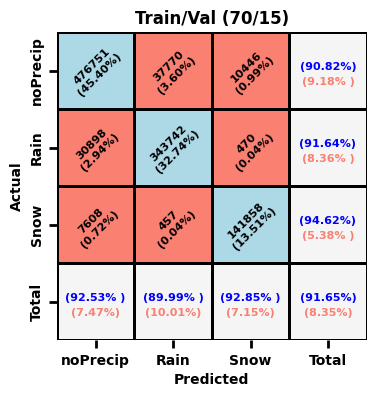

In [7]:
input_vars = ['10v', '10h', '18v', '18h','23v','36v', '36h', '89v', '89h', '166v', '166h','183-3', '183-7',
                        'tciw','tclw','tcwv','t2m','cape','u10', 'v10', 'skt','asn', 'rsn', 'cin', 
              'sd', 'tcslw','tcw','swvl1','lsm', 'siconc', 'Latitude','Longitude', 'Month', 'Day', 'mean_aspect', 'elevation_mean']
x_train_70_era5 = df_70_train_era5[input_vars]
y_train_70_era5 = df_70_train_era5['Prcp flag']

x_test_15_era5 = df_15_test_era5[input_vars]
y_test_15_era5 = df_15_test_era5['Prcp flag']

x_val_15_era5 = df_15_val_era5[input_vars]
y_val_15_era5 = df_15_val_era5['Prcp flag']

dtrain = xgb.DMatrix(x_train_70_era5, label=y_train_70_era5)
dtest = xgb.DMatrix(x_test_15_era5, label=y_test_15_era5)
dval = xgb.DMatrix(x_val_15_era5, label=y_val_15_era5)

evals = [(dtrain, 'train'), (dtest, 'test'), (dval, 'val')]


params = {
    'objective': 'multi:softmax',
    'num_class': 3,
    'eval_metric': 'merror',
    'reg_alpha': 0.095,
    'reg_lambda': 7.843,
    'max_depth': 18,
    'num_parallel_tree': 3,
    'learning_rate': 0.330808,
    'gamma': 0.661776,
    'verbosity': 0
}

booster_era5 = xgb.train(
    params=params,
    dtrain=dtrain,
    evals=evals,
    num_boost_round=93,
    verbose_eval=True
)

y_pred = booster_era5.predict(dtest)

plot_confusion_matrix(y_test_15_era5, y_pred, 'Predicted', 'Actual', 'Train/Val (70/15)')

In second round of training, architecture of trees trained on the ERA5 will be frozen -- that is, their structure, including the number of trees, depth, nodes, and splitting criteria, is fixed. Additional bottom boosters are then appended and trained on satellite-based observations to capture the finer-scale information embedded in active retrievals.

In [17]:
x_train_70_cpr = df_70_train_cpr[input_vars]
y_train_70_cpr = df_70_train_cpr['Prcp flag']

x_test_15_cpr = df_15_test_cpr[input_vars]
y_test_15_cpr = df_15_test_cpr['Prcp flag']

x_val_15_cpr = df_15_val_cpr[input_vars]
y_val_15_cpr = df_15_val_cpr['Prcp flag']

x_era5 = df_15_test_era5[input_vars]
y_era5 = df_15_test_era5['Prcp flag']

classes = np.unique(df_70_train_cpr['Prcp flag'])                         
class_weights = {0: 1, 1: 1.167, 2: 1.566}


sample_weights_70 = df_70_train_cpr['Prcp flag'].map(lambda x: class_weights[classes.tolist().index(x)])


dtrain_cpr = xgb.DMatrix(x_train_70_cpr, label=y_train_70_cpr, weight=sample_weights_70)
dtest_cpr = xgb.DMatrix(x_test_15_cpr, label=y_test_15_cpr)
dval_cpr = xgb.DMatrix(x_val_15_cpr, label=y_val_15_cpr)
dera5 = xgb.DMatrix(x_era5, label=y_era5)

evals = [(dtrain_cpr, 'train_cpr'), (dtest_cpr, 'test_cpr'), (dval_cpr, 'val_cpr'), (dera5, 'era5')]

f1_train_cpr_rain_values, f1_test_cpr_rain_values, f1_val_cpr_rain_values, f1_era5_rain_values = [], [], [], []
f1_train_cpr_snow_values, f1_test_cpr_snow_values, f1_val_cpr_snow_values, f1_era5_snow_values = [], [], [], []

def f1_eval_all_classes(preds, dtrain):
    labels = dtrain.get_label()
    preds = preds.argmax(axis=1)
    f1_scores = f1_score(labels, preds, labels=[1, 2], average=None)
    f1_rain, f1_snow = f1_scores[0], f1_scores[1]

    if dtrain == dtrain_cpr:
        f1_train_cpr_rain_values.append(f1_rain)
        f1_train_cpr_snow_values.append(f1_snow)
    elif dtrain == dtest_cpr:
        f1_test_cpr_rain_values.append(f1_rain)
        f1_test_cpr_snow_values.append(f1_snow)
    elif dtrain == dera5:
        f1_era5_rain_values.append(f1_rain)
        f1_era5_snow_values.append(f1_snow)
    elif dtrain == dval_cpr:
        f1_val_cpr_rain_values.append(f1_rain)
        f1_val_cpr_snow_values.append(f1_snow)

    return 'f1_snow', f1_snow

# Set parameters
params = {
    'objective': 'multi:softmax',
    'num_class': 3,
    'eval_metric': 'merror',
    'subsample': 0.5,
    'reg_alpha': 6.948,
    'reg_lambda': 5.0278,
    'max_depth': 18,
    'num_parallel_tree': 6,
    'learning_rate': 0.018,
    'gamma': 0.32,
    'verbosity': 0
}

# Train with the new data
booster = xgb.train(
    params,
    dtrain_cpr,
    num_boost_round=182,
    evals=evals,
    xgb_model=booster_era5,
    verbose_eval=True,
    feval=f1_eval_all_classes
)

# Final model evaluation
y_pred_cpr_finetune = booster.predict(dtest_cpr)
accuracy = accuracy_score(y_test_15_cpr, y_pred_cpr_finetune)
print(f"Test accuracy: {accuracy:.2f}")

C:\Users\subed042\AppData\Local\anaconda3\envs\Created\Lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	train_cpr-merror:0.21849	train_cpr-f1_snow:0.82153	test_cpr-merror:0.23721	test_cpr-f1_snow:0.82099	val_cpr-merror:0.24222	val_cpr-f1_snow:0.81925	era5-merror:0.08343	era5-f1_snow:0.93739
[1]	train_cpr-merror:0.21714	train_cpr-f1_snow:0.82200	test_cpr-merror:0.23577	test_cpr-f1_snow:0.82144	val_cpr-merror:0.24061	val_cpr-f1_snow:0.82019	era5-merror:0.08343	era5-f1_snow:0.93750
[2]	train_cpr-merror:0.21582	train_cpr-f1_snow:0.82283	test_cpr-merror:0.23430	test_cpr-f1_snow:0.82250	val_cpr-merror:0.23898	val_cpr-f1_snow:0.82051	era5-merror:0.08370	era5-f1_snow:0.93753
[3]	train_cpr-merror:0.21447	train_cpr-f1_snow:0.82337	test_cpr-merror:0.23283	test_cpr-f1_snow:0.82322	val_cpr-merror:0.23743	val_cpr-f1_snow:0.82125	era5-merror:0.08407	era5-f1_snow:0.93760
[4]	train_cpr-merror:0.21289	train_cpr-f1_snow:0.82421	test_cpr-merror:0.23112	test_cpr-f1_snow:0.82363	val_cpr-merror:0.23588	val_cpr-f1_snow:0.82147	era5-merror:0.08450	era5-f1_snow:0.93766
[5]	train_cpr-merror:0.21160	train_cpr-f

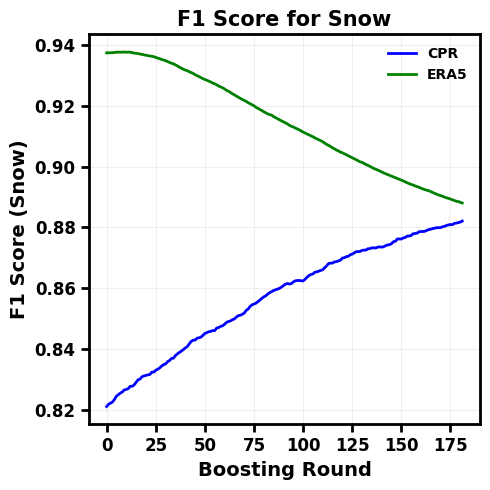

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.plot(f1_test_cpr_snow_values, label='CPR', color='blue', linewidth=2)
plt.plot(f1_era5_snow_values, label='ERA5', color='green', linewidth=2)

# Axis labels and title
plt.xlabel('Boosting Round', fontsize=14, fontweight='bold')
plt.ylabel('F1 Score (Snow)', fontsize=14, fontweight='bold')
plt.title('F1 Score for Snow', fontsize=15, fontweight='bold')

# Legend
plt.legend(fontsize=12, frameon=False, loc='best', prop={'weight': 'bold'})

# Tick labels
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Tick size
plt.tick_params(axis='both', which='major', length=6, width=2)

# Make axis spines bold
for spine in plt.gca().spines.values():
    spine.set_linewidth(2)

plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

Train the Model for CPR snow regression

In [19]:
import numpy as np
import pandas as pd

paths = {
    'ERA5 Snow Rate': r'G:\Shared drives\SAFL Ebtehaj Group\Buddha Research\Research 1\data\df_era5_snow_rate.npz',
    'CPR Snow Rate':  r'G:\Shared drives\SAFL Ebtehaj Group\Buddha Research\Research 1\data\df_csat_snow_rate.npz'
}

# Load data
data = {k: np.load(p) for k, p in paths.items()}
df_era5_snow_rate, df_cpr_snow_rate = (pd.DataFrame({k: v[k] for k in v.files}) for v in data.values())

# Print total number of samples using shape
for name, df, sep in zip(
    ['ERA5', 'CPR'],
    [df_era5_snow_rate, df_cpr_snow_rate],
    ['##############################', '']
):
    print(f"**{name}**")
    print(f"Total samples for Snow Retrievals: {df.shape[0]}")
    if sep: print(sep)

**ERA5**
Total samples for Snow Retrievals: 1000000
##############################
**CPR**
Total samples for Snow Retrievals: 47123


In [29]:
df_era5_snow_rate.columns

Index(['10v', '10h', '18v', '18h', '23v', '36v', '36h', '89v', '89h', '166v',
       '166h', '183-3', '183-7', 'tciw', 'tclw', 'tcwv', 't2m', 'cape', 'u10',
       'v10', 'cin', 'skt', 'asn', 'rsn', 'sd', 'tcslw', 'tcw', 'swvl1', 'lsm',
       'siconc', 'Latitude', 'Longitude', 'Month', 'Day', 'mean_aspect',
       'elevation_mean', 'snow_rate'],
      dtype='object')

In [67]:
snowr_input = ['10v', '10h', '18v', '18h','23v','36v', '36h', '89v', '89h', '166v', '166h','183-3', '183-7',
                        'tciw','tclw','tcwv','t2m','cape','u10', 'v10','cin', 'skt','asn', 'rsn',
              'sd', 'tcslw','tcw','swvl1','lsm', 'siconc', 'Latitude','Longitude', 'Month', 'Day', 'mean_aspect', 'elevation_mean']

df_70_train_snow_era5, df_30_snow_era5 = train_test_split(df_era5_snow_rate, test_size=0.7, random_state=42)
df_15_test_snow_era5, df_15_val_snow_era5 = train_test_split(df_30_snow_era5, test_size=0.5, random_state=42)

X_70_train_snow_era5 = df_70_train_snow_era5[snowr_input]
y_70_train_snow_era5 = df_70_train_snow_era5['snow_rate']

X_15_test_snow_era5 = df_15_test_snow_era5[snowr_input]
y_15_test_snow_era5 = df_15_test_snow_era5['snow_rate']

X_15_val_snow_era5 = df_15_val_snow_era5[snowr_input]
y_15_val_snow_era5 = df_15_val_snow_era5['snow_rate']

# Define the parameters for XGBoost
params = {
    'objective': 'reg:squarederror',
    'seed': 42,
    'learning_rate': 0.061,
    'max_depth': 14,
    'reg_alpha':2.637,
    'reg_lambda': 0.005,
    'n_estimators': 92,
    'num_parallel_tree': 5
}

# Convert data into DMatrix format
dtrain_snow_era5 = xgb.DMatrix(X_70_train_snow_era5, label=y_70_train_snow_era5)
dtest_snow_era5 = xgb.DMatrix(X_15_test_snow_era5, label=y_15_test_snow_era5)
dval_snow_era5 = xgb.DMatrix(X_15_val_snow_era5, label=y_15_val_snow_era5)

# Dictionary to store evaluation results
evals_result = {}

# Train the model and capture evaluation results
model = xgb.train(
    params,
    dtrain_snow_era5,
    num_boost_round=92,
    evals=[(dtrain_snow_era5, 'train'), (dval_snow_era5, 'validation'), (dtest_snow_era5, 'test')],
    evals_result=evals_result,
    verbose_eval=True
)

[0]	train-rmse:0.19882	validation-rmse:0.19900	test-rmse:0.19940
[1]	train-rmse:0.19031	validation-rmse:0.19080	test-rmse:0.19120
[2]	train-rmse:0.18243	validation-rmse:0.18327	test-rmse:0.18365
[3]	train-rmse:0.17512	validation-rmse:0.17623	test-rmse:0.17660
[4]	train-rmse:0.16836	validation-rmse:0.16977	test-rmse:0.17017
[5]	train-rmse:0.16209	validation-rmse:0.16386	test-rmse:0.16423
[6]	train-rmse:0.15630	validation-rmse:0.15847	test-rmse:0.15881
[7]	train-rmse:0.15092	validation-rmse:0.15347	test-rmse:0.15379
[8]	train-rmse:0.14594	validation-rmse:0.14888	test-rmse:0.14919
[9]	train-rmse:0.14136	validation-rmse:0.14467	test-rmse:0.14497
[10]	train-rmse:0.13713	validation-rmse:0.14086	test-rmse:0.14113
[11]	train-rmse:0.13319	validation-rmse:0.13734	test-rmse:0.13761
[12]	train-rmse:0.12959	validation-rmse:0.13416	test-rmse:0.13441
[13]	train-rmse:0.12622	validation-rmse:0.13123	test-rmse:0.13144
[14]	train-rmse:0.12312	validation-rmse:0.12857	test-rmse:0.12878
[15]	train-rmse:0.12

### Fine tune on the CPR snow rate

In [68]:
#df_cpr_snow_rate = df_cpr_snow_rate[df_cpr_snow_rate['snow_rate'] < 20]
df_70_train_snow_cpr, df_30_snow_cpr = train_test_split(df_cpr_snow_rate, test_size=0.3, random_state=42)
df_15_test_snow_cpr, df_15_val_snow_cpr = train_test_split(df_30_snow_cpr, test_size=0.5, random_state=42)
# Separate features and target variable
X_70_train_snow_rate_cpr = df_70_train_snow_cpr[snowr_input]
y_70_train_snow_rate_cpr = df_70_train_snow_cpr['snow_rate']
X_15_test_snow_rate_cpr = df_15_test_snow_cpr[snowr_input]
y_15_test_snow_rate_cpr = df_15_test_snow_cpr['snow_rate']

X_15_val_snow_rate_cpr = df_15_val_snow_cpr[snowr_input]
y_15_val_snow_rate_cpr = df_15_val_snow_cpr['snow_rate']

dtrain_snow_rate_cpr = xgb.DMatrix(X_70_train_snow_rate_cpr, label=y_70_train_snow_rate_cpr)
dtest_snow_rate_cpr = xgb.DMatrix(X_15_test_snow_rate_cpr, label=y_15_test_snow_rate_cpr)
dval_snow_rate_cpr = xgb.DMatrix(X_15_val_snow_rate_cpr, label=y_15_val_snow_rate_cpr)

# Define evaluation metrics and watchlist
evals = [(dtest_snow_era5, 'test_era5'), (dtest_snow_rate_cpr, 'test'), (dval_snow_rate_cpr, 'val')]


params = {
    'objective': 'reg:squarederror',  # For regression tasks
    'learning_rate': 0.006,            # Lower learning rate for fine-tuning
    #'process_type': 'update',         # Important for fine-tuning
    #'updater': 'refresh',             # Keeps the existing trees, modifies only the new trees
    #'refresh_leaf': True,             # Updates the leaf values of the trees
    'eval_metric': 'rmse' ,            # Use RMSE as the evaluation metric for regression
    'max_depth':15
}

evals_result = {}  # Dictionary to store evaluation results

# Continue training with the new data
snow_rate_booster = xgb.train(
    params,
    dtrain_snow_rate_cpr,
    num_boost_round=184,
    evals=evals,
    evals_result=evals_result,  # Capture evaluation history
    xgb_model=model,
    verbose_eval=True
)


# Predict on the test set
y_pred_snow_rate_sat = snow_rate_booster.predict(dtest_snow_rate_cpr)

# Calculate the mean squared error or any other relevant metric
mse_new = mean_squared_error(y_15_test_snow_rate_cpr, y_pred_snow_rate_sat)
print(f"Test Mean Squared Error: {mse_new:.2f}")

[0]	test_era5-rmse:0.09508	test-rmse:0.30429	val-rmse:0.26945
[1]	test_era5-rmse:0.09508	test-rmse:0.30372	val-rmse:0.26875
[2]	test_era5-rmse:0.09510	test-rmse:0.30316	val-rmse:0.26807
[3]	test_era5-rmse:0.09514	test-rmse:0.30260	val-rmse:0.26738
[4]	test_era5-rmse:0.09519	test-rmse:0.30193	val-rmse:0.26668
[5]	test_era5-rmse:0.09529	test-rmse:0.30126	val-rmse:0.26599
[6]	test_era5-rmse:0.09536	test-rmse:0.30072	val-rmse:0.26534
[7]	test_era5-rmse:0.09552	test-rmse:0.30006	val-rmse:0.26467
[8]	test_era5-rmse:0.09573	test-rmse:0.29942	val-rmse:0.26401
[9]	test_era5-rmse:0.09582	test-rmse:0.29890	val-rmse:0.26336
[10]	test_era5-rmse:0.09609	test-rmse:0.29826	val-rmse:0.26272
[11]	test_era5-rmse:0.09640	test-rmse:0.29773	val-rmse:0.26208
[12]	test_era5-rmse:0.09675	test-rmse:0.29713	val-rmse:0.26144
[13]	test_era5-rmse:0.09687	test-rmse:0.29661	val-rmse:0.26082
[14]	test_era5-rmse:0.09700	test-rmse:0.29609	val-rmse:0.26019
[15]	test_era5-rmse:0.09740	test-rmse:0.29550	val-rmse:0.25960
[1

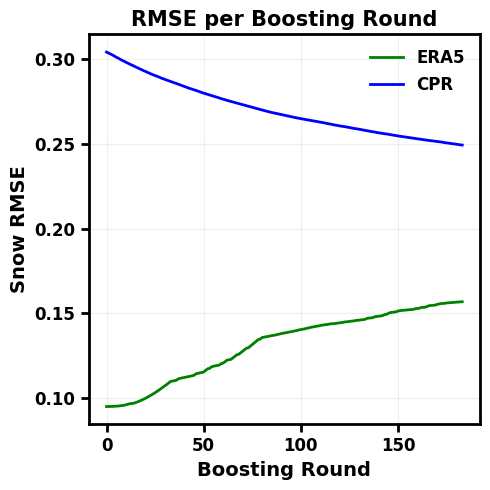

In [69]:
import matplotlib.pyplot as plt

# Extract RMSE values
rmse_test_era5 = evals_result['test_era5']['rmse']
rmse_test_cpr = evals_result['test']['rmse']

# Plot
plt.figure(figsize=(5, 5))
plt.plot(rmse_test_era5, label='ERA5', color='green', linewidth=2)
plt.plot(rmse_test_cpr, label='CPR', color='blue',linewidth=2)

# Labels and Title with bold font
plt.xlabel('Boosting Round', fontsize=14, fontweight='bold')
plt.ylabel('Snow RMSE', fontsize=14, fontweight='bold')
plt.title('RMSE per Boosting Round', fontsize=15, fontweight='bold')

# Legend (bold font, larger size)
legend = plt.legend(fontsize=12, frameon=False, fancybox=True, shadow=True)
for text in legend.get_texts():
    text.set_fontweight('bold')

# Tick labels and tick marks (make ticks bold and thick)
plt.tick_params(axis='both', labelsize=11, width=2, length=6)  # <- Adjust width and length here
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Bold plot borders (spines)
for spine in plt.gca().spines.values():
    spine.set_linewidth(2)
    spine.set_edgecolor('black')

plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

# **3.  Orbial Retrievals**

<img src="Fig_08.png" alt="Coincidence Image" width="800">